In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
sns.set_style('whitegrid')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../input/Data_Entry_2017.csv')
data = data[data['Patient Age']<100] #removing datapoints which having age greater than 100
data_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('..', 'input', 'images*', '*', '*.png'))}
print('Scans found:', len(data_image_paths), ', Total Headers', data.shape[0])
data['path'] = data['Image Index'].map(data_image_paths.get)
data['Patient Age'] = data['Patient Age'].map(lambda x: int(x))
data.sample(3)

Scans found: 112120 , Total Headers 112104


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
39361,00010314_010.png,Atelectasis|Infiltration,10,10314,67,M,AP,2500,2048,0.168,0.168,NaN,../input/images_005/images/00010314_010.png
32007,00008365_003.png,No Finding,3,8365,70,F,AP,2500,2048,0.168,0.168,NaN,../input/images_004/images/00008365_003.png
27810,00007239_004.png,No Finding,4,7239,52,F,AP,2500,2048,0.168,0.168,NaN,../input/images_004/images/00007239_004.png


In [3]:
#data['Finding Labels'] = data['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*data['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        data[c_label] = data['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
data.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
103815,00027715_000.png,No Finding,0,27715,22,F,PA,2286,2341,0.143,0.143,NaN,../input/images_011/images/00027715_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59355,00014674_023.png,No Finding,23,14674,46,M,PA,2992,2991,0.143,0.143,NaN,../input/images_007/images/00014674_023.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
63191,00015606_038.png,No Finding,38,15606,18,F,AP,2500,2048,0.168,0.168,NaN,../input/images_007/images/00015606_038.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
data.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
82107,00020204_007.png,Effusion,7,20204,34,F,PA,2538,2991,0.143,0.143,NaN,../input/images_009/images/00020204_007.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112092,00030786_002.png,Cardiomegaly|Effusion|Emphysema|Pneumothorax,2,30786,61,F,AP,3056,2544,0.139,0.139,NaN,../input/images_012/images/00030786_002.png,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78866,00019363_030.png,No Finding,30,19363,55,F,AP,2500,2048,0.168,0.168,NaN,../input/images_009/images/00019363_030.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [5]:
MIN_CASES = 0
all_labels = [c_label for c_label in all_labels if data[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(data[c_label].sum())) for c_label in all_labels])

Clean Labels (15) [('Atelectasis', 11558), ('Cardiomegaly', 2776), ('Consolidation', 4667), ('Edema', 2302), ('Effusion', 13316), ('Emphysema', 2516), ('Fibrosis', 1686), ('Hernia', 227), ('Infiltration', 19891), ('Mass', 5779), ('No Finding', 60353), ('Nodule', 6331), ('Pleural_Thickening', 3384), ('Pneumonia', 1430), ('Pneumothorax', 5301)]


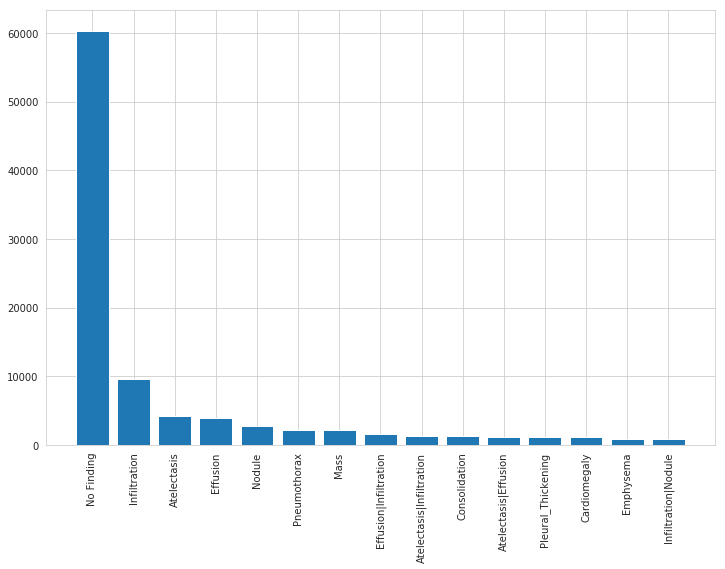

In [6]:
sample_weights = data['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
data = data.sample(112104, weights=sample_weights)

label_counts = data['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [7]:
data['disease_vec'] = data.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [8]:
#data['disease_vec'] = data.drop(sum(data['disease_vec'])>1, axis = 1)
data.drop(data[ (data['Atelectasis'] + data['Cardiomegaly'] + data['Consolidation'] + data['Edema'] + data['Effusion'] +
                 data['Emphysema'] + data['Fibrosis'] + data['Hernia'] + data['Infiltration'] + data['Mass'] +
                 data['No Finding'] + data['Nodule'] + data['Pleural_Thickening'] + data['Pneumonia']
                 + data['Pneumothorax']) > 1].index, inplace = True)

In [9]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(data, 
                                   test_size = 0.20, 
                                   random_state = 20,
                                   stratify = data['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'test', test_df.shape[0])

train 73049 test 18263


In [10]:
train_df, valid_df = train_test_split(train_df, 
                                   test_size = 0.10, 
                                   random_state = 20,
                                   stratify = train_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'valid', valid_df.shape[0])

train 65744 valid 7305


In [11]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [12]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [13]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16)

valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 16) # we can use much larger batches for evaluation
# used a fixed dataset for evaluating the algorithm
test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               test_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024)) # one big batch

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 65744 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 7305 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 18263 images


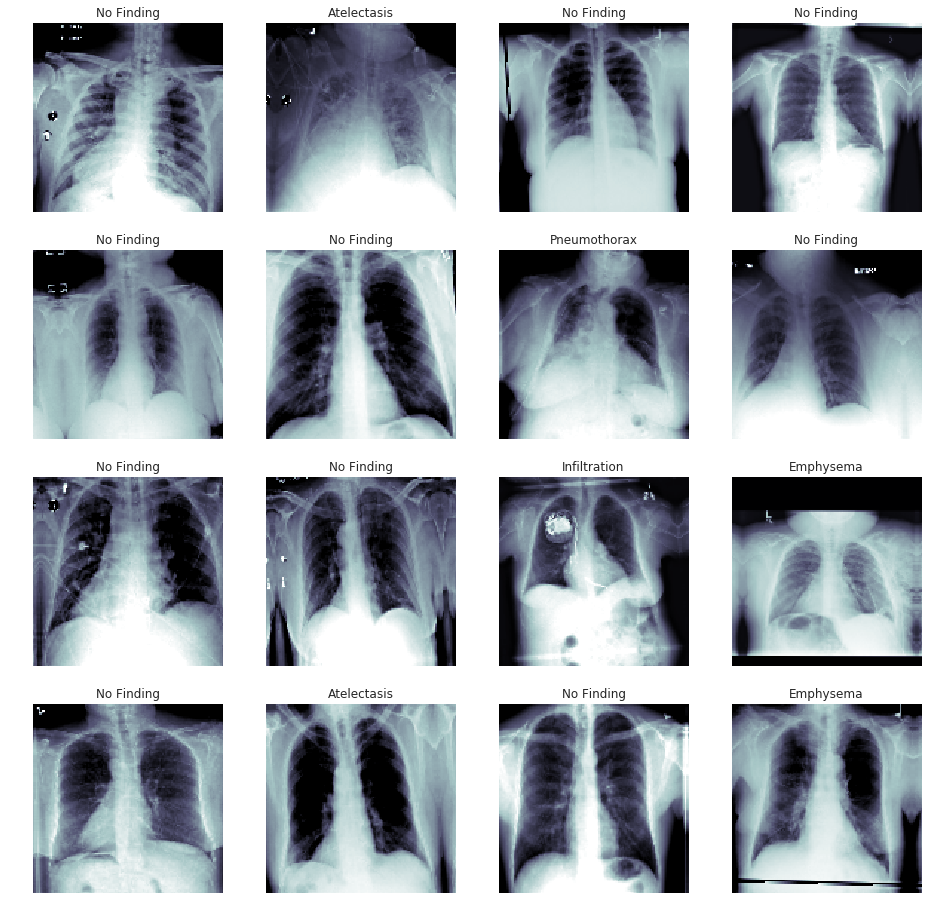

In [14]:

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

In [15]:
from keras import backend as K

def binary_accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def precision_threshold(threshold = 0.5):
    def precision(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(y_pred)
        precision_ratio = true_positives / (predicted_positives + K.epsilon())
        return precision_ratio
    return precision

def recall_threshold(threshold = 0.5):
    def recall(y_true, y_pred):
        threshold_value = threshold
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold_value), K.floatx())
        true_positives = K.round(K.sum(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.clip(y_true, 0, 1))
        recall_ratio = true_positives / (possible_positives + K.epsilon())
        return recall_ratio
    return recall

def fbeta_score_threshold(beta = 1, threshold = 0.5):
    def fbeta_score(y_true, y_pred):
        threshold_value = threshold
        beta_value = beta
        p = precision_threshold(threshold_value)(y_true, y_pred)
        r = recall_threshold(threshold_value)(y_true, y_pred)
        bb = beta_value ** 2
        fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
        return fbeta_score
    return fbeta_score

In [ ]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNet(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'softmax'))#sigmoid
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=[precision_threshold(threshold = 0.5), 
                           recall_threshold(threshold = 0.5), 
                           fbeta_score_threshold(beta=0.5, threshold = 0.5),
                           fbeta_score_threshold(beta=1, threshold = 0.5),
                          'accuracy'])
multi_disease_model.summary()


In [20]:
##################################temporary

from keras.applications.mobilenetv2 import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
mobilenet_model = MobileNetV2(input_shape =  t_x.shape[1:], 
                                 include_top = False, weights = None)
multi_disease_model = Sequential()
multi_disease_model.add(mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
#
multi_disease_model.add(Dense(768))
multi_disease_model.add(Dropout(0.5))
#
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics=[precision_threshold(threshold = 0.5), 
                           recall_threshold(threshold = 0.5), 
                           fbeta_score_threshold(beta=0.5, threshold = 0.5),
                          'accuracy'])
multi_disease_model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 4, 4, 1280)        2257408   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 768)               983808    
_________________________________________________________________
dropout_5 (Dropout)          (None, 768)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               393728    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
__________

In [28]:
history = multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = valid_gen, 
                                  validation_steps = 20,
                                  epochs = 30)#30

Epoch 1/30
  9/100 [=>............................] - ETA: 1:01 - loss: 0.2139 - precision: 0.6978 - recall: 0.5694 - fbeta_score: 0.6663 - acc: 0.9546

KeyboardInterrupt: 

In [27]:
score = multi_disease_model.evaluate(test_X, test_Y)
print('Test values:\n loss: ' ,score[0], '  precision: ', 
      score[1],'recall: ', score[2],' fbeta_score_1: ',score[3],' acc: ', score[4])

1024/1024 [==============================] - 1s 498us/step
 loss:  0.0745396614074707   precision:  0.90 recall:  0.90  fbeta_score_1:  0.90  acc:  0.9658286054059863


In [ ]:
print(score)

In [ ]:
####################precison and recall
from sklearn.metrics import classification_report

y_pred = multi_disease_model.predict(test_X)
print(y_pred[0])

yy = y_pred.round()

for i in range(0, 1024):
    maxV = 0
    maxL = -1
    for j in range(0, 15):
        if(y_pred[i][j] > maxL):
            #print(y_pred[i][j])
            maxV = yy[i][j]
            maxL = j
        else:
            yy[i][j] = 0 
    yy[i][maxL] = maxV
            
print(classification_report(np.argmax(test_Y, axis=1), np.argmax(yy, axis=1)))
########precsion recall end

In [ ]:
#test_Y.shape
y_pred.shape
test_Y[6]
y_pred[6]
yy[6]

yy = pd.DataFrame(data = yy)
ty = pd.DataFrame(data = test_Y)


yy = np.array(yy)
ty = np.array(ty)
'''for i in range(13):
    i = str(i)
    if
    yy[i] = '''
#yy.head()

In [ ]:
plt.plot(history.history['acc'], label='training accuracy')
plt.plot(history.history['val_acc'], label='test accuracy')
plt.legend()
plt.title('Multiclass classification CNN accuracy per epoch')
plt.show()


In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.title('loss per epoch')
plt.show()

In [ ]:
import tensorflow as tf
#model = Sequential(weights= "cnn_xray.h5")
#model.load_weights("cnn_xray.h5")
new_model = tf.keras.models.load_model('cnn_xray_multiclass_softmax.h5')

In [ ]:
new_model.predict(test_X)

In [ ]:
#######################################new